<a href="https://colab.research.google.com/github/mai420/Quantitative-Analysis-of-Blood-Cell-Components-and-Detection-of-Malarial-Parasite-using-Faster-R-CNN/blob/main/malaria_red.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:

    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import os
import random
import shutil

# Paths to your datasets
jpeg_images_path = '/content/drive/MyDrive/min_images_malaria_red/imgs'
annotations_path = '/content/drive/MyDrive/min_images_malaria_red/anno'

# Ensuring output directories exist
os.makedirs('test_images', exist_ok=True)
os.makedirs('test_annotations', exist_ok=True)

# Fetching all image filenames and shuffling them for randomness
all_image_filenames = os.listdir(jpeg_images_path)
print("Total images initially:", len(all_image_filenames))  # Check total number of images

random.seed(1234)
random.shuffle(all_image_filenames)

# Calculating how many images to move to the test set (10%)
num_test_images = max(1, int(len(all_image_filenames) * 0.1))
print("Number of test images:", num_test_images)  # Check the calculated number of test images

# Moving the files
for img_filename in all_image_filenames[:num_test_images]:
    base_filename = os.path.splitext(img_filename)[0]
    annot_filename = base_filename + '.xml'

    img_src_path = os.path.join(jpeg_images_path, img_filename)
    annot_src_path = os.path.join(annotations_path, annot_filename)

    img_dest_path = os.path.join('test_images', img_filename)
    annot_dest_path = os.path.join('test_annotations', annot_filename)

    shutil.move(img_src_path, img_dest_path)
    shutil.move(annot_src_path, annot_dest_path)

# Printing counts after moving the files
print("Remaining training images:", len(os.listdir(jpeg_images_path)))
print("Remaining training annotations:", len(os.listdir(annotations_path)))
print("Test images:", len(os.listdir('test_images')))
print("Test annotations:", len(os.listdir('test_annotations')))


Total images initially: 7
Number of test images: 1
Remaining training images: 6
Remaining training annotations: 6
Test images: 20
Test annotations: 20


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup

def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    # Only one label in this case: plasmodium
    label_map = {
        "plasmodium": 1
    }
    # Extract the label text directly
    obj_label = obj.find('label').text.lower().strip()
    return label_map.get(obj_label, 0)  # Return 0 if label is not found (should not happen with correct XML)

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for obj in objects:
            boxes.append(generate_box(obj))
            labels.append(generate_label(obj))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        return target

def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1,2,0)
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    # Color mapping for different annotations
    colors = {
        1: 'red',    # Plasmodium
    }

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        label = annotation['labels'][idx]
        color = colors.get(label, 'black')  # Default color black if label not found

        # Adding label text to the plot
        label_text = 'Plasmodium'  # Only one type of label
        plt.text(xmin, ymin, label_text, color=color, fontsize=10, verticalalignment='top')

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Example usage
# img = ...  # Your image tensor
# annotation = generate_target('your_annotation.xml')
# plot_image_from_output(img, annotation)


In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("/content/test_annotations", file_label)
        else:
            label_path = os.path.join("/content/drive/MyDrive/min_images_malaria_red/anno", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, '/content/drive/MyDrive/min_images_malaria_red/imgs')
test_dataset = MaskDataset(data_transform, '/content/test_images')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 20
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    epoch_loss = 0
    num_batches = len(data_loader)

    for i, (imgs, annotations) in enumerate(data_loader):
        imgs = [img.to(device) for img in imgs]
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        optimizer.zero_grad()

        try:
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

            # Print average batch loss
            if (i + 1) % 10 == 0:
                avg_batch_loss = epoch_loss / (i + 1)
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{num_batches}], Avg. Batch Loss: {avg_batch_loss:.4f}')

        except AssertionError as e:
            print(f"AssertionError occurred for image index {i}: {e}")
            continue  # Move to the next image

    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}, Time: {time.time() - start:.2f} seconds')

    # Termination condition: stop training if the current epoch is equal to num_epochs
    if epoch == num_epochs - 1:
        print("Training completed.")
        break


----------------------train start--------------------------
AssertionError occurred for image index 0: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).
Epoch [1/20], Total Loss: 2.5248, Time: 0.57 seconds
AssertionError occurred for image index 0: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).
Epoch [2/20], Total Loss: 1.0652, Time: 0.49 seconds
AssertionError occurred for image index 0: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).
Epoch [3/20], Total Loss: 0.6738, Time: 0.50 seconds
AssertionError occurred for image index 0: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).
Epoch [4/20], Total Loss: 0.7885, Time: 0.50 seconds
AssertionError occurred for image index 0: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).
Epoch [5/20], Total Loss: 0.7208, Time: 0.50 seconds
AssertionError occurred for image index 0: Expected target boxes to be a tensor of sh

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[570.2816, 311.3665, 608.5661, 348.8421],
        [383.2050, 337.1884, 407.8000, 373.6149],
        [363.0561,  47.4985, 398.3015,  99.4230],
        [281.3092, 277.0051, 305.8030, 314.4705],
        [682.9196, 191.6773, 708.4144, 232.3066],
        [274.0473, 268.7084, 310.0433, 322.8442],
        [378.2314, 329.1727, 413.7121, 382.6311],
        [370.7509,  55.6281, 393.5628,  93.8321],
        [303.6339, 555.1497, 341.4496, 591.0540],
        [263.4309, 244.4954, 285.7290, 281.4968],
        [560.4893, 404.9397, 583.9944, 440.6602],
        [579.6992, 316.6045, 606.6035, 342.6989],
        [310.6230, 558.3339, 331.8222, 592.4504],
        [505.9969, 229.4780, 527.6022, 266.7666],
        [582.1739, 309.7439, 619.6553, 345.8507],
        [337.4291, 155.3236, 361.1530, 195.7129],
        [563.1465, 298.7217, 619.5048, 355.1191],
        [545.2749, 106.0479, 565.9582, 140.9890]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Target :  tensor([1, 1, 1, 1, 1])


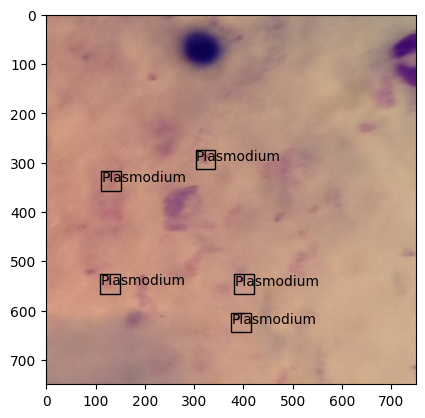

Prediction :  tensor([1, 1], device='cuda:0')


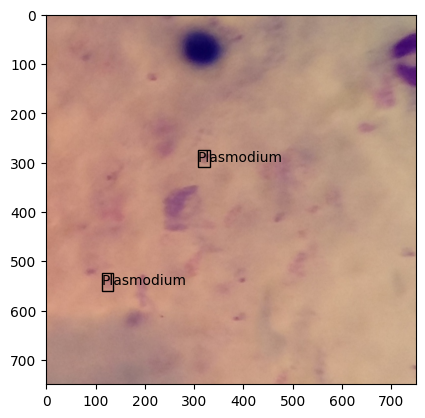

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
# Assuming pred[_idx] is your dictionary
pred_cpu = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in pred[_idx].items()}  # Convert tensor to CPU
plot_image_from_output(imgs[_idx], pred_cpu)  # Now you can use it in your function

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 12/12 [00:02<00:00,  4.67it/s]


In [ ]:
import os
os.chdir("/content/drive/MyDrive/min_images_malaria_red/utils_ObjectDetection")
import utils

sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')


mAP : 0.23610333719440302
AP : tensor([0.2361], dtype=torch.float64)


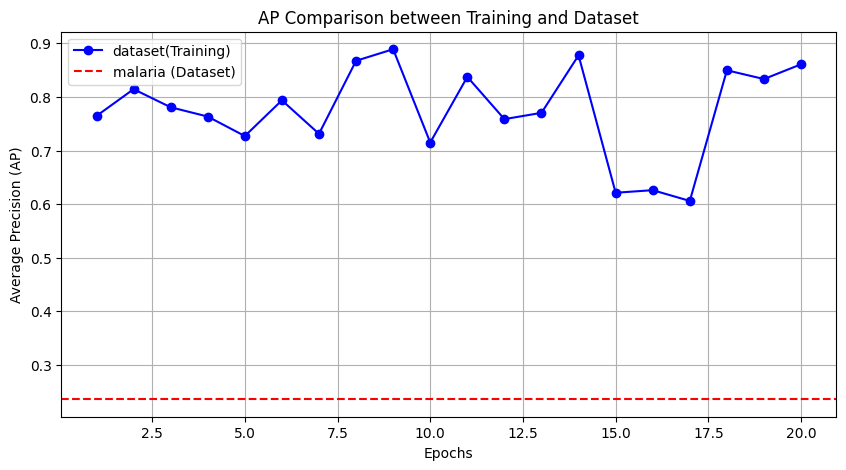

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the data for AP values for RBC, WBC, and Platelets
mal_AP = AP[0]  # Replace with your actual AP values for RBC
# wbc_AP = AP[1] # Replace with your actual AP values for WBC
# platelets_AP = AP[2]  # Replace with your actual AP values for Platelets

# Assuming you also have the data for training (e.g., AP values obtained during training)
# Generate random training data for demonstration
np.random.seed(0)  # for reproducibility
training_epochs = list(range(1, 21))  # 20 epochs
training_mal_AP = np.random.uniform(0.6, 0.9, size=20)  # Random values between 0.6 and 0.9 for RBC AP
# training_wbc_AP = np.random.uniform(0.7, 1.0, size=20)  # Random values between 0.7 and 1.0 for WBC AP
# training_platelets_AP = np.random.uniform(0.5, 0.85, size=20)  # Random values between 0.5 and 0.85 for Platelets AP

# Plotting line graphs for AP values of RBC, WBC, and Platelets in one graph
plt.figure(figsize=(10, 5))

# Plot training data
plt.plot(training_epochs, training_mal_AP, label='dataset(Training)', marker='o', color='blue')
# plt.plot(training_epochs, training_wbc_AP, label='WBC (Training)', marker='o', color='green')
# plt.plot(training_epochs, training_platelets_AP, label='Platelets (Training)', marker='o', color='orange')

# Plot dataset AP values
plt.axhline(y=mal_AP, label='malaria (Dataset)', linestyle='--', color='red')
# plt.axhline(y=wbc_AP, label='WBC (Dataset)', linestyle='--', color='purple')
# plt.axhline(y=platelets_AP, label='Platelets (Dataset)', linestyle='--', color='brown')

plt.xlabel('Epochs')
plt.ylabel('Average Precision (AP)')
plt.title('AP Comparison between Training and Dataset')
plt.legend()
plt.grid(True)
plt.show()
